In [ ]:
!apt-get -qq update && apt-get -qq install xxd

Selecting previously unselected package xxd.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTMCell, Dense,Embedding,RNN

In [ ]:

with open('/content/test_src.txt') as fsrc:
  with open('/content/test_tgt.txt') as ftgt:
    print (f'{"Source":20s} {"Target"}')
    for src, tgt, _ in zip(fsrc, ftgt, range(6)):
      print (f'{src.strip():20s} {tgt.strip()}')

Source               Target
8 6 1 9 5 7          eight hundred and sixty one thousand nine hundred and fifty seven
6 2 8 0 9 6 8        six million two hundred and eighty thousand nine hundred and sixty eight
8 4 5 4 4 2 7 6 7    eight hundred and forty five million four hundred and forty two thousand seven hundred and sixty seven
8 7 3 1 3            eighty seven thousand three hundred and thirteen
7 4 9 2 8 2 5 2 6 1  seven billion four hundred and ninety two million eight hundred and twenty five thousand two hundred and sixty one
7 0 9 4 2 7 2 8 9    seven hundred and nine million four hundred and twenty seven thousand two hundred and eighty nine


In [ ]:
# Build vocabulary from training data
train_src= []
train_tgt = []

with open('/content/train_src.txt') as fsrc:
  with open('/content/train_tgt.txt') as ftgt:
    for src, tgt in zip(fsrc, ftgt):
      train_src.append(src.strip())
      train_tgt.append('<s> ' + tgt.strip() + ' <e>')

print (f'Size of training set: {len(train_src)}')
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False)
src_tokenizer.fit_on_texts(train_src)

tgt_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False)
tgt_tokenizer.fit_on_texts(train_tgt)

SRC_SIZE = len(src_tokenizer.word_index) + 1
print(f'Size of source : {SRC_SIZE}')

TGT_SIZE = len(tgt_tokenizer.word_index) + 1
print(f'Size of target : {TGT_SIZE}')

src_vocab = []
for word in src_tokenizer.word_index:
  src_vocab.append(word)
tgt_vocab = []
for word in tgt_tokenizer.word_index:
  tgt_vocab.append(word)

Size of training set: 11723
Size of source : 11
Size of target : 35


In [ ]:
# Prepare training data
# encoder_input_data
tokenized_src = src_tokenizer.texts_to_sequences(train_src)
max_len_src = max([len(x) for x in tokenized_src])
padded_src = tf.keras.preprocessing.sequence.pad_sequences(tokenized_src, 
                                                           maxlen=max_len_src, 
                                                           padding='post')
encoder_input_data = np.array(padded_src)

# decoder_input_data
tokenized_tgt = tgt_tokenizer.texts_to_sequences(train_tgt)
max_len_tgt = max([len(x) for x in tokenized_tgt])
padded_tgt = tf.keras.preprocessing.sequence.pad_sequences(tokenized_tgt, 
                                                           maxlen=max_len_tgt, 
                                                           padding='post')
decoder_input_data = np.array(padded_tgt)

# decoder_output_data
tokenized_tgt = tgt_tokenizer.texts_to_sequences(train_tgt)
for i in range(len(tokenized_tgt)) :
  tokenized_tgt[i] = tokenized_tgt[i][1:]
padded_tgt = tf.keras.preprocessing.sequence.pad_sequences(tokenized_tgt, 
                                                           maxlen=max_len_tgt, 
                                                           padding='post')
onehot_tgt = tf.keras.utils.to_categorical(padded_tgt, TGT_SIZE)
decoder_output_data = np.array(onehot_tgt)

In [ ]:
# Prepare test data
src_test = []
tgt_test = []

with open('/content/test_src.txt') as fsrc:
  with open('/content/test_tgt.txt') as ftgt:
    for src, tgt in zip(fsrc, ftgt):
      src_test.append(src.strip())
      tgt_test.append('<s> ' + tgt.strip()+ ' <e>')

# encoder_input_data
tokenized_src_test = src_tokenizer.texts_to_sequences(src_test)
tokenized_src_test = [x[:max_len_src] for x in tokenized_src_test]
padded_src_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_src_test, 
                                                                maxlen=max_len_src, 
                                                                padding='post')
encoder_input_data_test = np.array(padded_src_test)

# decoder_input_data
tokenized_tgt_test = tgt_tokenizer.texts_to_sequences(tgt_test)
tokenized_tgt_test = [x[:max_len_tgt] for x in tokenized_tgt_test]
padded_tgt_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_tgt_test, 
                                                                maxlen=max_len_tgt, 
                                                                padding='post')
decoder_input_data_test = np.array(padded_tgt_test)

# decoder_output_data
tokenized_tgt_test = tgt_tokenizer.texts_to_sequences(tgt_test)
for i in range(len(tokenized_tgt_test)) :
  tokenized_tgt_test[i] = tokenized_tgt_test[i][1:]
padded_tgt_test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_tgt_test, 
                                                                maxlen=max_len_tgt, 
                                                                padding='post')
labels_test = np.array(padded_tgt_test)

In [ ]:
class AttnLSTMCell(tf.keras.layers.Layer):
  def __init__(self, hidden_size, output_size, **kwargs):
    self.h = hidden_size
    self.o = output_size

    self.state_size = tf.TensorShape([hidden_size])
    self.output_size = tf.TensorShape([output_size])

    super(AttnLSTMCell, self).__init__(**kwargs)

  def build(self, input_shapes):
    self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.h)

  def call(self, inputs, states):
    inputs, encoder_outputs = inputs
    outputs, new_states = self.decoder_lstm_cell(inputs, states)
    query = tf.keras.layers.Reshape((dec_hidden_size, 1))(outputs) 
    values = encoder_outputs 
    keys = values
    scores = tf.matmul(values, query) 
    scores = tf.keras.layers.Softmax(1)(scores) 
    context = scores * values 
    context_list = tf.split(context, num_or_size_splits=max_len_src, axis=1)
    context = context_list[0]
    for i in range(1, max_len_src):
      context = context + context_list[i]
    context = tf.keras.layers.Reshape((dec_hidden_size,))(context)
    outputs = tf.keras.layers.Concatenate(axis=-1)([context, outputs])
    
    return outputs, new_states

  def get_config(self):
    return {"hidden_size": self.h, "output_size": self.o}

In [ ]:
hidden_size = 64
enc_hidden_size = 32
dec_hidden_size = 64

src_embedding_size = 64
tgt_embedding_size = 64

# Input tensors:
# Encoder inputs
encoder_inputs = Input(shape=(max_len_src,)) 
decoder_inputs = Input(shape=(max_len_tgt,)) 

# Encoder
encoder_embedding_layer = Embedding(SRC_SIZE, src_embedding_size) 
encoder_embeddings = encoder_embedding_layer(encoder_inputs) 
encoder_lstm_cell_fw = LSTMCell(enc_hidden_size)
encoder_lstm_cell_bw = LSTMCell(enc_hidden_size)
encoder_lstm_layer_fw = RNN(encoder_lstm_cell_fw, 
                            return_sequences=True, 
                            return_state=True, 
                            go_backwards=False)
encoder_lstm_layer_bw = RNN(encoder_lstm_cell_bw, 
                            return_sequences=True, 
                            return_state=True, 
                            go_backwards=True)

encoder_lstm_layer = tf.keras.layers.Bidirectional(encoder_lstm_layer_fw, 
                                                   merge_mode='concat',
                                                   backward_layer=encoder_lstm_layer_bw)
# Reset bidirectional since Bidirectional creates new cells
encoder_lstm_cell_fw = encoder_lstm_layer.forward_layer.cell 
encoder_lstm_cell_bw = encoder_lstm_layer.backward_layer.cell
encoder_outputs, encoder_states_h_fw, encoder_states_c_fw, encoder_states_h_bw, encoder_states_c_bw = encoder_lstm_layer(encoder_embeddings)
encoder_states_h = tf.keras.layers.Concatenate(axis=1)([encoder_states_h_fw, encoder_states_h_bw])
encoder_states_c = tf.keras.layers.Concatenate(axis=1)([encoder_states_c_fw, encoder_states_c_bw])
encoder_states = (encoder_states_h, encoder_states_c)

# Decoder
decoder_embedding_layer = Embedding(TGT_SIZE, tgt_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs) 

decoder_lstm_cell = AttnLSTMCell(dec_hidden_size, TGT_SIZE)
decoder_proj_layer = tf.keras.layers.Dense(TGT_SIZE)

logits = []
decoder_state = encoder_states
context = None
for t in range(max_len_tgt):
  decoder_embedding = decoder_embeddings[:, t]
  if context is not None:
    decoder_embedding = decoder_embedding + context
  decoder_output, decoder_state = decoder_lstm_cell([decoder_embedding, encoder_outputs], decoder_state)
  logit = decoder_proj_layer(decoder_output)
  context = decoder_output[:, :dec_hidden_size]
  logits.append(logit)

decoder_logits = tf.stack(logits, 1)


# Compile model

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_logits)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              experimental_run_tf_function=False),


model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 21)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 10, 64)       704         ['input_19[0][0]']               
                                                                                                  
 embedding_9 (Embedding)        (None, 21, 64)       2240        ['input_20[0][0]']               
                                                                                            

In [ ]:
# Train model
BATCH_SIZE = 16
EPOCHS = 60
history=model.fit([encoder_input_data, decoder_input_data], 
          decoder_output_data, 
          batch_size=BATCH_SIZE, 
          validation_split=0.05,
          epochs=EPOCHS) 

Epoch 1/60
696/696 [==============================] - 21s 23ms/step - loss: 0.0141 - accuracy: 0.9989 - val_loss: 0.0129 - val_accuracy: 0.9989
Epoch 2/60
696/696 [==============================] - 16s 22ms/step - loss: 0.0089 - accuracy: 0.9991 - val_loss: 0.0076 - val_accuracy: 0.9991
Epoch 3/60
696/696 [==============================] - 14s 20ms/step - loss: 0.0064 - accuracy: 0.9993 - val_loss: 0.0059 - val_accuracy: 0.9992
Epoch 4/60
696/696 [==============================] - 14s 20ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.0038 - val_accuracy: 0.9995
Epoch 5/60
696/696 [==============================] - 14s 20ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 6/60
696/696 [==============================] - 14s 19ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9997
Epoch 7/60
696/696 [==============================] - 14s 20ms/step - loss: 9.6613e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accur

In [ ]:
model.save("/content/model_o.h5")

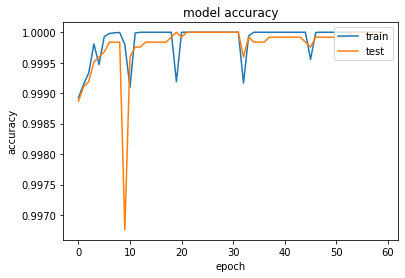

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')



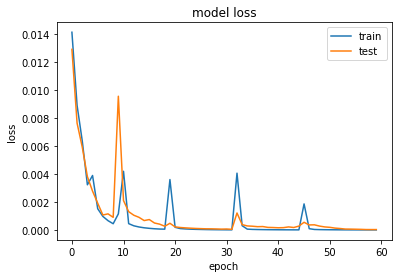

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
# Evaluate model
total = 0
correct = 0
for encoder_input_d, decoder_input_d, label_d in zip(encoder_input_data_test, 
                                                     decoder_input_data_test, 
                                                     labels_test):
  encoder_input_d = encoder_input_d.reshape((1, -1))
  decoder_input_d = decoder_input_d.reshape((1, -1))
  label_d = label_d.reshape((1, -1))
  logits = model.predict_on_batch([encoder_input_d, decoder_input_d])
  predictions = logits.argmax(-1)
  if (predictions == label_d).all():
    correct += 1
  total +=1
print (f'Test accuracy: {100.0*correct/total}%')

Test accuracy: 99.8%


In [ ]:
from tensorflow.lite.python.lite import TFLiteConverter
# Create tflite model
# Encoder LSTM Cell (left-to-right)
# Inputs

encoder_embedding_fw = Input(shape=(src_embedding_size,)) 
encoder_state_h_fw = Input(shape=(enc_hidden_size,)) 
encoder_state_c_fw = Input(shape=(enc_hidden_size,))

encoder_output_fw, (encoder_state_h_out_fw, encoder_state_c_out_fw) = encoder_lstm_cell_fw(encoder_embedding_fw,  (encoder_state_h_fw, encoder_state_c_fw))

enc_fw_micro_model =  tf.keras.models.Model([encoder_embedding_fw, 
                                             encoder_state_h_fw, 
                                             encoder_state_c_fw], 
                                            [encoder_output_fw, 
                                             encoder_state_h_out_fw, 
                                             encoder_state_c_out_fw])
enc_fw_micro_model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(enc_fw_micro_model)

#converter.optimizations=[tf.lite.Optimize.DEFAULT]
buffer_enc_fw = converter.convert()
open('enc_model_fw.tflite', 'wb').write(buffer_enc_fw)

# Encoder LSTM Cell (right-to-left)
# Inputs
encoder_embedding_bw = Input(shape=(src_embedding_size,)) 
encoder_state_h_bw = Input(shape=(enc_hidden_size,)) 
encoder_state_c_bw = Input(shape=(enc_hidden_size,)) 

encoder_output_bw, (encoder_state_h_out_bw, encoder_state_c_out_bw) = encoder_lstm_cell_bw(encoder_embedding_bw, (encoder_state_h_bw, encoder_state_c_bw))

enc_bw_micro_model =  tf.keras.models.Model([encoder_embedding_bw, 
                                             encoder_state_h_bw, 
                                             encoder_state_c_bw], 
                                            [encoder_output_bw, 
                                             encoder_state_h_out_bw, 
                                             encoder_state_c_out_bw])
enc_bw_micro_model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(enc_bw_micro_model)
#converter.optimizations=[tf.lite.Optimize.DEFAULT]
buffer_enc_bw = converter.convert()
open('enc_model_bw.tflite', 'wb').write(buffer_enc_bw)

# Decoder LSTM Cell
# Inputs
encoder_output = Input(shape=(max_len_src, dec_hidden_size,)) 
decoder_embedding = Input(shape=(tgt_embedding_size,)) 
decoder_state_h = Input(shape=(dec_hidden_size,)) 
decoder_state_c = Input(shape=(dec_hidden_size,)) 

decoder_output, (decoder_state_h_out, decoder_state_c_out) = decoder_lstm_cell([decoder_embedding, encoder_output], (decoder_state_h, decoder_state_c))
decoder_context = decoder_output[:, :dec_hidden_size]
decoder_logit = decoder_proj_layer(decoder_output) 


dec_micro_model =  tf.keras.models.Model([encoder_output, 
                                          decoder_embedding, 
                                          decoder_state_h, 
                                          decoder_state_c], 
                                         [decoder_logit, 
                                          decoder_context, 
                                          decoder_state_h_out, 
                                          decoder_state_c_out])
dec_micro_model.summary()

converter = tf.lite.TFLiteConverter.from_keras_model(dec_micro_model)
#converter.optimizations=[tf.lite.Optimize.DEFAULT]
buffer_dec = converter.convert()
open('dec_model.tflite' , 'wb').write(buffer_dec)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 lstm_cell_6 (LSTMCell)         ((None, 32),         12416       ['input_9[0][0]',                
                                 [(None, 32),                     'input_10[0][0]',         

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 lstm_cell_7 (LSTMCell)         ((None, 32),         12416       ['input_12[0][0]',               
                                 [(None, 32),                     'input_13[0][0]',         

INFO:tensorflow:Assets written to: /tmp/tmpayqbplmj/assets


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 10, 64)]     0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 64)]         0           []                               
                                                                                            

INFO:tensorflow:Assets written to: /tmp/tmpzirq3zl0/assets


INFO:tensorflow:Assets written to: /tmp/tmpzirq3zl0/assets


160520

In [ ]:
dec_model=os.path.getsize("dec_model.tflite")
print(dec_model)
enc_model_fw=os.path.getsize("enc_model_fw.tflite")
print(enc_model_fw)
enc_model_bw=os.path.getsize("enc_model_bw.tflite")
print(enc_model_bw)

160520
53344
53348


In [ ]:
# Create C files for Arduino

model_h_file = 'model.h'
model_cpp_file = 'model.cpp'

# model.h
for word, index in tgt_tokenizer.word_index.items():
  if word == '<s>':
    bos_word_id = index
  elif word == '<e>':
    eos_word_id = index
model_h_str = f"""
#ifndef MODEL_H_
#define MODEL_H_

#include "Arduino.h"
#include "tensorflow/lite/c/common.h"

extern const unsigned char g_enc_model_fw[];
extern const unsigned char g_enc_model_bw[];
extern const unsigned char g_dec_model[];
void set_enc_embed(TfLiteTensor* ptr, String token);
void set_dec_embed(TfLiteTensor* ptr, String token);
String id_to_word(int idx);

const int max_len_src = {max_len_src};
const int max_len_tgt = {max_len_tgt};
const int bos_word_id = {bos_word_id};
const int eos_word_id = {eos_word_id};
const int enc_hidden_size = {enc_hidden_size};
const int dec_hidden_size = {dec_hidden_size};
const int src_embedding_size = {src_embedding_size};
const int tgt_embedding_size = {tgt_embedding_size};
const int src_vocab_size = {SRC_SIZE};
const int tgt_vocab_size = {TGT_SIZE};
#endif
"""

with open(model_h_file, 'w') as fout:
  fout.write(model_h_str)

# model.cpp - enc rnn left-to-right
!xxd -i  enc_model_fw.tflite > tmp

with open('tmp') as fin:
  with open(model_cpp_file, 'w') as fout:
    text = fin.read().strip()
    lines = list(text.split('\n'))
    fout.write('#include "model.h"\n')
    fout.write('alignas(8) const unsigned char g_enc_model_fw[] = {\n')
    for line in lines[1:-1]:
      fout.write(line + '\n')

# model.cpp - enc rnn right-to-left
!xxd -i  enc_model_bw.tflite > tmp

with open('tmp') as fin:
  with open(model_cpp_file, 'a') as fout:
    text = fin.read().strip()
    lines = list(text.split('\n'))
    fout.write('alignas(8) const unsigned char g_enc_model_bw[] = {\n')
    for line in lines[1:-1]:
      fout.write(line + '\n')

# model.cpp - dec rnn
!xxd -i  dec_model.tflite > tmp

with open('tmp') as fin:
  with open(model_cpp_file, 'a') as fout:
    text = fin.read().strip()
    lines = list(text.split('\n'))
    fout.write('alignas(8) const unsigned char g_dec_model[] = {\n')
    for line in lines[1:-1]:
      fout.write(line + '\n')

# model.cpp - embeddings
def to_c(array):
  return '{' + ','.join([ '{' + ','.join([str(i) for i in item]) + '}' for item in array]) + '}'

src_embeddings_str = to_c(model.trainable_variables[0].numpy())
src_vocab_str = '{' + ",".join(['"' + item + '"' for item in src_vocab]) + '}'
enc_embedding_str = f"""
void set_enc_embed(TfLiteTensor* ptr, String token) {{
  float embeddings[src_vocab_size][src_embedding_size] = {src_embeddings_str};
  const char *words[src_vocab_size-1] = {src_vocab_str};
  int word_id = 0;
  for (int i = 1; i < src_vocab_size; i++) {{
    String token2 = words[i-1];
    if (token == token2) {{
      word_id = i;
      break;
    }}
  }}
  for (int i = 0; i < src_embedding_size; i++) {{
    ptr->data.f[i] = embeddings[word_id][i];
  }}
}}
"""

with open(model_cpp_file, 'a') as fout:
  fout.write('\n')
  fout.write(enc_embedding_str)

tgt_embeddings_str = to_c(model.trainable_variables[1].numpy())
tgt_vocab_str = '{' + ",".join(['"' + item + '"' for item in tgt_vocab]) + '}'
dec_embedding_str = f"""
void set_dec_embed(TfLiteTensor* ptr, String token) {{
  float embeddings[tgt_vocab_size][tgt_embedding_size] = {tgt_embeddings_str};
  const char *words[tgt_vocab_size-1] = {tgt_vocab_str};
  int word_id = 0;
  for (int i = 1; i < tgt_vocab_size; i++) {{
    String token2 = words[i-1];
    if (token == token2) {{
      word_id = i;
      break;
    }}
  }}
  for (int i = 0; i < tgt_embedding_size; i++) {{
    ptr->data.f[i] = embeddings[word_id][i];
  }}
}}

String id_to_word(int idx) {{
  const char *words[tgt_vocab_size-1] = {tgt_vocab_str};
  if (idx == 0) {{
    return String("pad");
  }}
  String str = words[idx-1];
  return str;
}}
"""

with open(model_cpp_file, 'a') as fout:
  fout.write('\n')
  fout.write(dec_embedding_str)